# Intepretation of Gradient Boosting Machine Models For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *09/26/2021*
***
**Description:**
Notebook for the interpretation of random forest model predictions
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading webpages
from scipy import stats
from IPython.display import IFrame
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

import torch

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Define parameters of the notebook

In [3]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "ohe-seq"  # What features to use to train the model
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
SUBSET = False
HYPERPARAM = "baseline"
ARCHITECTURE = "EUGENE"

# Load data

In [4]:
X = np.load('../data/{0}/{1}/X_{2}_{3}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES, PREPROCESS))

In [5]:
y = np.loadtxt('../data/{0}/y_binary_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=int)
IDs = np.loadtxt('../data/{0}/sequence_id_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=str)
dataframe = pd.read_csv("../data/{0}/20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv".format(DATASET.replace("-", "_")), sep="\t", na_values="na")
IDs[0], X[0, :4], y[0], IDs.shape, X.shape, y.shape

('S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6',
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]]),
 1,
 (302936,),
 (302936, 66, 4),
 (302936,))

In [6]:
dataframe = dataframe[~dataframe["MPRA_FXN"].isna()].set_index("NAME")
dataframe.head(1)

,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA
NAME,,,,
S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767


## **Train/test split**

In [7]:
X_train, X_test, y_train, y_test, IDs_train, IDs_test = train_test_split(X, y, IDs, train_size=0.9, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, IDs_train.shape, IDs_test.shape

((272642, 66, 4), (30294, 66, 4), (272642,), (30294,), (272642,), (30294,))

In [8]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

In [9]:
# need to fix this in the EDA
X_train = np.transpose(X_train, axes=(0, 2, 1))
X_test = np.transpose(X_test, axes=(0, 2, 1))

## Load model

In [11]:
from EUGENE import EUGENE
test_eugene = EUGENE()
test_eugene.load_state_dict(torch.load("0.18-0.4_ohe-seq_EUGENE-clf_baseline.pt", map_location=torch.device('cpu')))
test_eugene.eval()

EUGENE(
  (Conv1): Conv1d(4, 32, kernel_size=(16,), stride=(1,))
  (Conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (Batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Maxpool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (Drop1): Dropout(p=0.5, inplace=False)
  (Linear1): Linear(in_features=1472, out_features=1, bias=True)
)

In [12]:
y_tr_outputs = test_eugene(torch.tensor(X_train).float()).detach()
y_tr_probs = torch.sigmoid(y_tr_outputs).detach().numpy().reshape(-1)
y_tr_preds = np.round(y_tr_probs).reshape(-1).astype(int)

In [13]:
y_outputs = test_eugene(torch.tensor(X_test).float()).detach()
y_probs = torch.sigmoid(y_outputs).detach().numpy().reshape(-1)
y_preds = np.round(y_probs).reshape(-1).astype(int)

# Analysis of missed predictions

### <u>**Confusion matrices** </u>

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
np.unique(y_tr_preds, return_counts=True), np.unique(y_preds, return_counts=True)

((array([0, 1]), array([254766,  17876])),
 (array([0, 1]), array([28341,  1953])))

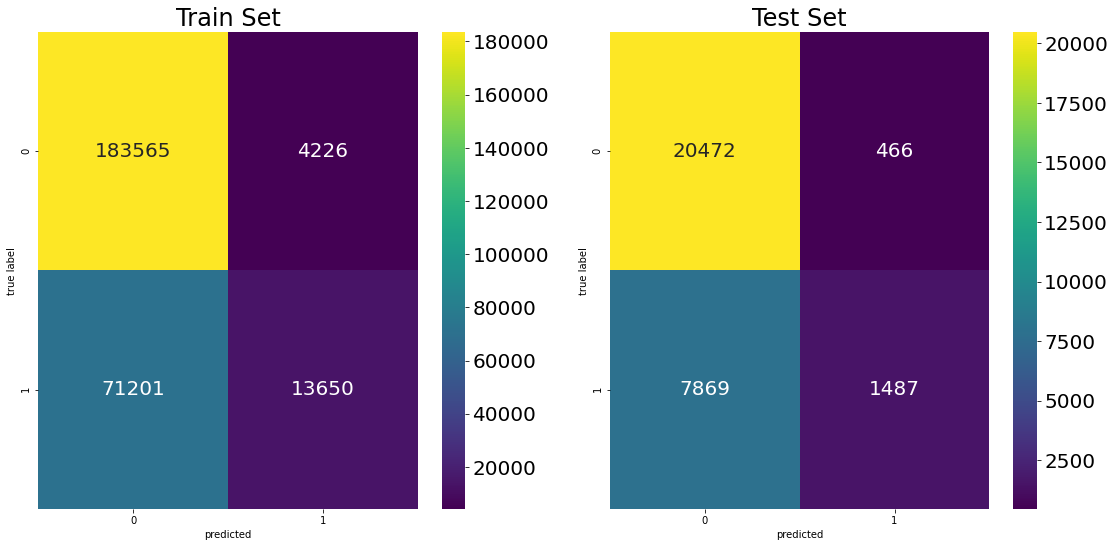

In [16]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
rc = {"font.size" : 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')

    fig.tight_layout();

#### Train

In [17]:
clf_train_df = pd.DataFrame(index=IDs_train, data={"labels": y_train, "preds":y_tr_preds, "probability":y_tr_probs})
clf_train_df.index.name = "NAME"
train_df = pd.merge(dataframe, clf_train_df, left_index=True, right_index=True)
train_df["classification"] = ["-".join(list(value)) for value in train_df[["labels", "preds"]].values.astype(str)]
train_df["classification"] = train_df["classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
train_df["classification"].value_counts()
train_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
train_df = train_df[np.abs(stats.zscore(train_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

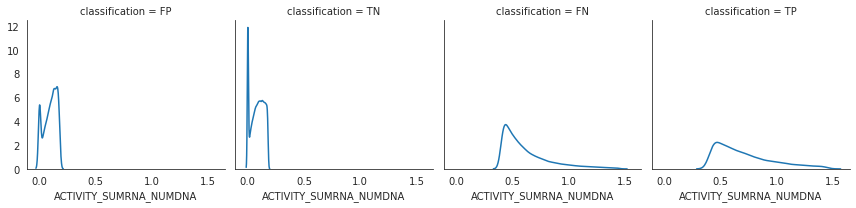

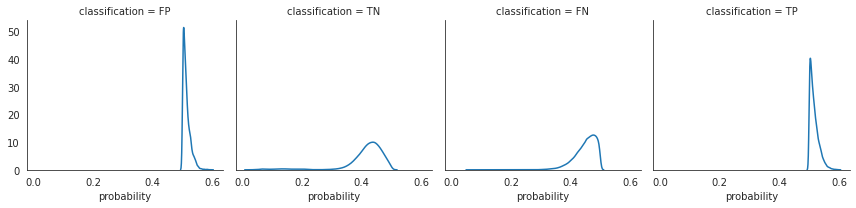

In [18]:
sns.set_style("white")
g = sns.FacetGrid(train_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g.map(sns.kdeplot, "ACTIVITY_SUMRNA_NUMDNA")
g2 = sns.FacetGrid(train_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g2.map(sns.kdeplot, "probability")

#### Test

In [19]:
clf_test_df = pd.DataFrame(index=IDs_test, data={"labels": y_test, "preds":y_preds, "probability":y_probs})
clf_test_df.index.name = "NAME"
test_df = pd.merge(dataframe, clf_test_df, left_index=True, right_index=True)
test_df["classification"] = ["-".join(list(value)) for value in test_df[["labels", "preds"]].values.astype(str)]
test_df["classification"] = test_df["classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["classification"].value_counts()
test_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
test_df = test_df[np.abs(stats.zscore(test_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

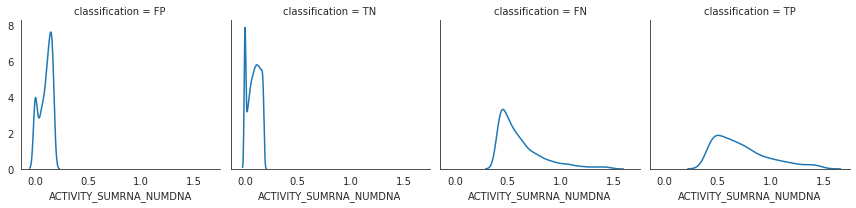

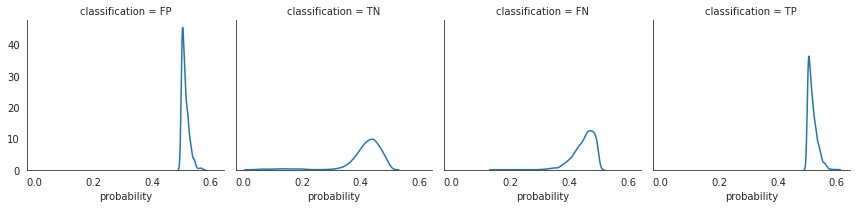

In [20]:
sns.set_style("white")
g = sns.FacetGrid(test_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g.map(sns.kdeplot, "ACTIVITY_SUMRNA_NUMDNA")
g2 = sns.FacetGrid(test_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g2.map(sns.kdeplot, "probability")

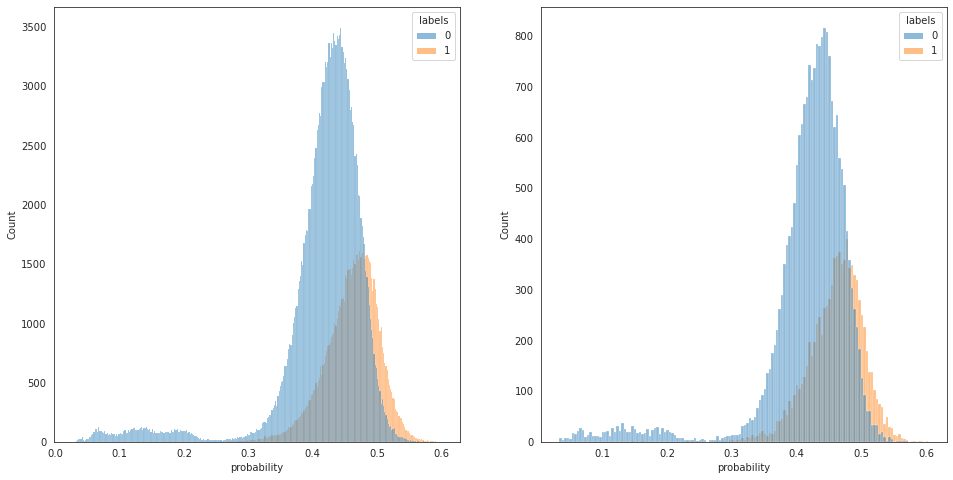

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.histplot(data=train_df, x="probability", hue="labels", ax=ax[0])
sns.histplot(data=test_df, x="probability", hue="labels", ax=ax[1]);

# Feature importances